In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

In [3]:
import scipy.io
from datetime import datetime, timedelta
import time
import sys, os
import itertools
import numpy
from collections import deque

In [4]:
matlab_filename = 'realitymining.mat'
print("Loading in matlab data - this takes a while and about 2gb memory")
matlab_obj = scipy.io.loadmat(matlab_filename)
print("Done loading matlab data.")

Loading in matlab data - this takes a while and about 2gb memory
Done loading matlab data.


In [5]:
def validSubjects(allSubjects):
    return [s for s in allSubjects if hasNumeric(s,'mac') and hasNumeric(s,'my_hashedNumber')]


# idDicts: subjects -> {int: subject}, {float: (int, subject)}, {int: (int, subject)}
# First hash is contiguousId: subjectObject
# second hash is macAddress: contiguousId, subjectObject
# third hash is hashedNumber: contiguousId, subjectObject
# because the id dictionaries reference the subject object, we can replace
# the array of subject objects with these dictionaries.

def idDicts(subjects):
    return (dict((i, s) for (i,s) in enumerate(subjects)),
        dict((getNumeric(s,'mac'), (i, s)) for (i,s) in enumerate(subjects)),
        dict((getNumeric(s, 'my_hashedNumber'), (i, s)) for (i,s) in enumerate(subjects)))

def hasNumeric(obj, field):
    try:
        obj[field][0][0]
        return True
    except:
        return False
    
def getNumeric(obj, field):
    return obj[field][0][0]

def hasArray(obj, field):
    try:
        obj[field][0]
        return True
    except:
        return False


def getArray(obj, field):
    return obj[field][0]

def convertDatetime(dt):
    return datetime.fromordinal(int(dt)) + timedelta(days=dt%1) - timedelta(days=366) - timedelta(hours=5)

In [6]:
print('Extracting valid subjects and creating id dictionaries.')
subjects = validSubjects(matlab_obj['s'][0])
idDictionaries = idDicts(subjects)

Extracting valid subjects and creating id dictionaries.


In [7]:
def createSMSDataset(idDictionaries):
#     startDate = 1095984000
#     endDate = 1105142400

#    this data contains the subject records as well
    idDict, macDict, hashNumDict = idDictionaries

    events = []
    for subjectId, subject in idDict.items():
        if hasArray(subject, 'comm_sms_date'):
            events.extend([[subjectId, convertDatetime(float(event))] for event in subject['comm_sms_date']])
    print("%d total comm events" % len(events))
            
    return events

In [8]:
SMSevents = createSMSDataset(idDictionaries)

5269 total comm events


In [9]:
SMSevents[0:10]

[[0, datetime.datetime(2004, 8, 3, 18, 33, 36, 999996)],
 [0, datetime.datetime(2004, 8, 4, 9, 5, 10, 2)],
 [0, datetime.datetime(2004, 8, 4, 9, 5, 43, 999998)],
 [0, datetime.datetime(2004, 8, 6, 23, 6, 25, 999995)],
 [0, datetime.datetime(2004, 8, 18, 21, 15, 31, 999997)],
 [0, datetime.datetime(2004, 8, 19, 9, 3, 0, 3)],
 [0, datetime.datetime(2004, 8, 23, 7, 30, 32, 999995)],
 [0, datetime.datetime(2004, 8, 26, 22, 7, 36, 1)],
 [0, datetime.datetime(2004, 8, 27, 21, 28, 49)],
 [0, datetime.datetime(2004, 8, 29, 15, 4, 33, 999996)]]

In [10]:
def create_loc_Dataset(idDictionaries):
#     startDate = 1095984000
#     endDate = 1105142400

#    this data contains the subject records as well
    idDict, macDict, hashNumDict = idDictionaries
    
    events = []
    for subjectId, subject in idDict.items():
        if hasArray(subject, 'locs'):
            for event in subject['locs']:
                try: 
                    timeplace = list(event)
                    time = convertDatetime(timeplace[0])
                    place = timeplace[1]
                    events.extend([[subjectId, time, place]])
                except:
                    pass
    print("%d total loc events" % len(events))
                
    return events

In [11]:
loc_events = create_loc_Dataset(idDictionaries)

3087363 total loc events


In [12]:
le = np.array(loc_events)

In [13]:
len(le)

3087363

In [14]:
smse = np.array(SMSevents)
print(len(smse))

5269


In [72]:
user = 0
len(le[np.where(le[:,0]==user)])

80910

In [23]:
SMSregressiondict = {}
usercount = 0
textcount = 0

for user in range(0,89):
    usercount += 1
    user_loc_events = le[np.where(le[:,0]==user)]
    user_SMSevents = smse[np.where(smse[:,0]==user)]

    start_loc_ind = 0
    end_loc_ind = len(user_loc_events)

    for text in range(0, len(user_SMSevents)):
        textcount += 1
        hour = le[text][1].hour
        
        for loc in range(start_loc_ind, end_loc_ind-1):
            if user_loc_events[loc][1] <= user_SMSevents[text][1] and user_loc_events[loc+1][1] > user_SMSevents[text][1]:
                place = int(user_loc_events[loc][2])
                
                try:
                    SMSregressiondict[(place, hour)] += 1
                except:
                    SMSregressiondict[(place, hour)] = 1
                    
                start_loc_ind = loc-1
                break
        if end_loc_ind == 0: break
        if user_SMSevents[text][1] > user_loc_events[end_loc_ind-1][1]:
            place = int(user_loc_events[end_loc_ind-1][2])
            try:
                SMSregressiondict[(place, hour)] += 1
            except:
                SMSregressiondict[(place, hour)] = 1
                
print(usercount, "users")
print(textcount, "texts")

89 users
5260 texts


In [23]:
dictbycell = {}
usercount = 0
textcount = 0

for user in range(0,89):
    usercount += 1
    user_loc_events = le[np.where(le[:,0]==user)]
    user_SMSevents = smse[np.where(smse[:,0]==user)]

    start_loc_ind = 0
    end_loc_ind = len(user_loc_events)

    for text in range(0, len(user_SMSevents)):
        textcount += 1
        hour = le[text][1].hour
        
        for loc in range(start_loc_ind, end_loc_ind-1):
            if user_loc_events[loc][1] <= user_SMSevents[text][1] and user_loc_events[loc+1][1] > user_SMSevents[text][1]:
                place = user_loc_events[loc][2]
                
                try:
                    dictbycell[(place, hour)] += 1
                except:
                    dictbycell[(place, hour)] = 1
                    
                start_loc_ind = loc-1
                break
        if end_loc_ind == 0: break
        if user_SMSevents[text][1] > user_loc_events[end_loc_ind-1][1]:
            place = user_loc_events[end_loc_ind-1][2]
            try:
                dictbycell[(place, hour)] += 1
            except:
                dictbycell[(place, hour)] = 1
                
print(usercount, "users")
print(textcount, "texts")

89 users
5260 texts


In [16]:
SMSregressiondict

{(5123, 15): 12,
 (0, 15): 23,
 (5123, 16): 70,
 (5119, 16): 431,
 (5123, 17): 27,
 (7804, 17): 1,
 (29702, 17): 3,
 (39402, 17): 1,
 (0, 17): 25,
 (5119, 17): 129,
 (5123, 18): 31,
 (5119, 18): 112,
 (5123, 21): 3,
 (5119, 3): 23,
 (5123, 3): 5,
 (5123, 4): 73,
 (5119, 4): 204,
 (5119, 5): 72,
 (5123, 5): 13,
 (5123, 6): 21,
 (5119, 6): 86,
 (0, 6): 10,
 (17, 6): 1,
 (5123, 7): 8,
 (5119, 7): 44,
 (5123, 8): 7,
 (5119, 8): 69,
 (5188, 8): 122,
 (5188, 9): 24,
 (31901, 9): 1,
 (5188, 10): 108,
 (20185, 10): 1,
 (10107, 10): 1,
 (25701, 10): 7,
 (25701, 11): 6,
 (360, 11): 1,
 (0, 11): 4,
 (0, 12): 2,
 (7803, 12): 1,
 (5188, 12): 22,
 (5188, 13): 6,
 (5188, 14): 23,
 (5188, 18): 63,
 (5188, 19): 5,
 (5188, 5): 66,
 (1200, 15): 3,
 (1300, 15): 1,
 (1000, 16): 1,
 (1200, 16): 4,
 (43801, 16): 1,
 (5113, 16): 27,
 (27407, 16): 5,
 (5113, 17): 14,
 (0, 18): 29,
 (5113, 18): 32,
 (1200, 18): 2,
 (104, 18): 1,
 (260, 18): 3,
 (0, 21): 2,
 (275, 21): 1,
 (5188, 3): 7,
 (5119, 15): 90,
 (32102,

In [27]:
len(dictbycell)
print(sum(dictbycell.values()))

4903


In [26]:
len(SMSregressiondict)
# print(sum(SMSregressiondict.values()))

NameError: name 'SMSregressiondict' is not defined

In [28]:
max(dictbycell.values())

117

In [17]:
import matplotlib.pyplot as plt

(array([312.,  17.,  10.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.,  44.,  87., 130., 173., 216., 259., 302., 345., 388., 431.]),
 <a list of 10 Patch objects>)

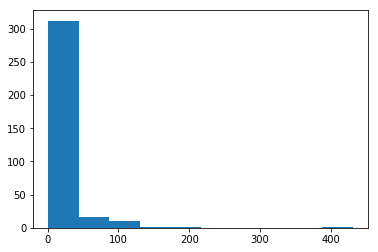

In [20]:
plt.hist(list(SMSregressiondict.values()))

(array([991.,  60.,  14.,   8.,   4.,   2.,   0.,   1.,   0.,   1.]),
 array([  1. ,  12.6,  24.2,  35.8,  47.4,  59. ,  70.6,  82.2,  93.8,
        105.4, 117. ]),
 <a list of 10 Patch objects>)

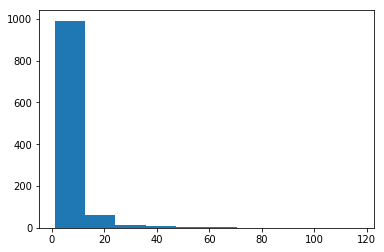

In [29]:
plt.hist(list(dictbycell.values()))

In [21]:
SMSclassificationdict = {}

for (place, time) in SMSregressiondict.keys():
    if SMSregressiondict[(place, time)] < 2:
        SMSclassificationdict[(place, time)] = 0
    elif SMSregressiondict[(place, time)] < 5:
        SMSclassificationdict[(place, time)] = 1
    elif SMSregressiondict[(place, time)] < 20:
        SMSclassificationdict[(place, time)] = 2
    else:
        SMSclassificationdict[(place, time)] = 3

(array([102.,   0.,   0., 105.,   0.,   0.,  76.,   0.,   0.,  59.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

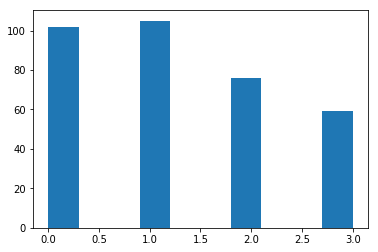

In [22]:
plt.hist(list(SMSclassificationdict.values()))

In [54]:
SMSclassificationdictbycell = {}

for (place, time) in dictbycell.keys():
    if dictbycell[(place, time)] < 2:
        SMSclassificationdictbycell[(place, time)] = 0
    elif dictbycell[(place, time)] < 3:
        SMSclassificationdictbycell[(place, time)] = 1
    elif dictbycell[(place, time)] < 6:
        SMSclassificationdictbycell[(place, time)] = 2
    else:
        SMSclassificationdictbycell[(place, time)] = 3

(array([501.,   0.,   0., 171.,   0.,   0., 187.,   0.,   0., 222.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

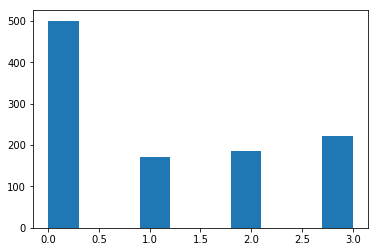

In [55]:
plt.hist(list(SMSclassificationdictbycell.values()))

In [56]:
data = np.array(list(SMSclassificationdictbycell.keys()))
labels = np.array(list(SMSclassificationdictbycell.values()))

In [57]:
N = len(SMSclassificationdictbycell)

In [64]:
order = np.argsort(np.random.random(labels.shape))
n = 900
train_data = data[order][0:n]
train_labels = labels[order][0:n]
test_data = data[order][n:N]
test_labels = labels[order][n:N]
print("Training set: {}".format(train_data.shape))
print("Testing set:  {}".format(test_data.shape))

Training set: (900, 2)
Testing set:  (181, 2)


In [65]:
best_accuracy = 0
for numunits in [2]:
# for numunits in [5]:
    for epochs in [100]:
#     for epochs in [100]:
        for numlayers in [1]:
#         for numlayers in [1]:
            print("Hidden Units:", numunits, "Epochs:", epochs, "Hidden Layers:", numlayers)
            model = keras.Sequential()
            for i in range(numlayers):
                model.add(keras.layers.Dense(numunits, activation=tf.nn.relu))
            model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
            
            model.compile(optimizer=tf.train.AdamOptimizer(), 
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            class PrintDot(keras.callbacks.Callback):
                def on_epoch_end(self, epoch, logs):
                    if epoch % 100 == 0: print('')
                    print('.', end='')

            model.fit(train_data, train_labels, epochs, verbose=0)

            class PrintDot(keras.callbacks.Callback):
                def on_epoch_end(self, epoch, logs):
                    if epoch % 100 == 0: print('')
                    print('.', end='')

            model.fit(train_data, train_labels, epochs=500, verbose=0)

            test_loss, test_acc = model.evaluate(test_data, test_labels)

            print('Test accuracy:', test_acc)
            if test_acc > best_accuracy:
                best_accuracy = test_acc
                print("BEST")
            print("")

Hidden Units: 2 Epochs: 100 Hidden Layers: 1
181/181 [==============================] - 6s 33ms/step
Test accuracy: 0.4309392273426056
BEST



For classifying by AREA: 1 hidden layer, 5 hidden units, and 100 epochs resulted in the best accuracy for 300 training points and 42 test points (accuracy of 39%)

For classifying by AREA and CELL:

In [73]:
predictions = model.predict(data)
# np.argmax(predictions[1])

3

In [76]:
import random

In [80]:
for i in range(1000):
    newpoint = np.array([[random.random()*10000, random.random()*24]])
    guess = np.argmax(model.predict(newpoint))
    if guess != 0:
        print(guess)